## Simulation of the CPU Thermal Behavior in Free-running and in DVFS-controlled mode Using a Simple RC Network

## 1. Objective and input data
Perform a thermal simulation of a CPU using a simple RC thermal model in two cases: 
1. Free-running mode:
    
    The CPU operates at a fixed nominal voltage and frequency without any thermal control.

2. DVFS-controlled mode:
    
    The CPU starts at nominal voltage and frequency but dynamically reduces both if the temperature exceeds a defined threshold (85°C), in order to keep the temperature capped below this limit.

![alt text](image.png)

Graph of the CPU Thermal Model Based on a Simple RC Circuit

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Dict

In [2]:
def get_default_params() -> Dict:
   
    """Return the default parameters of the RC model"""
    
    return {
        # Simulation constants
        "dt": 0.01,  # (ms)    10ms time step
        "duration": 10,  # (s) seconds

        # Synthetic Cdyn_nom trace
        "cdyn_nom_trace_range": (0.1, 1),  # (W/GHz)

        # Thermal RC parameters
        "R1": 100,  # CPU to SoC (K/W)
        "C_cpu": 0.005,  # (J/°C)

        "R2": 300,  # SoC to Board (K/W)
        "C_board": 3.0,  # (J/°C)

        "R3": 60,  # Board to Ambient (K/W)

        "R4": 30,  # SoC to Package (K/W)
        "C_pkg": 5.0,  # (J/°C)

        "R5": 30,  # Package to Ambient (K/W)
        "T_amb": (273.15 + 25.0),  # (K) soit : 25 °C

        # Power constants
        "pleak_nom": 0.1,  # (W) at v_nom and T_nom
        "T_nom": 300,  # (K), nominal temp for leakage power

        "v_nom": 0.75,  # (V)
        "f_nom": 2,  # (GHz)

        "v_min": 0.55,  # (V)
        "f_min": 0.4,  # (GHz)

        "dvfs_temp_limit": (273.15 + 85.0),  # (K), corresponding to 85°C
    }

## 2. Power Consumption Models

### 2.1 Dynamic Power (P_dyn)

Fundamental dynamic power consumption equation:
$$P_{dyn} = C_{dyn} \times f \times V^{2}$$

Parameters:
- $P_{dyn}$ (W): Dynamic power consumption
- $C_{dyn}$ (F): Effective switched capacitance (Farads)
- $f$ (Hz): Operating clock frequency.
- $V$ (V): Supply voltage.

The equation is derived from the fundamental CMOS power consumption formula:
   
   $$P_{dyn} = \alpha \times C \times V^2 \times f$$
   
   where:
   * $\alpha$: activity factor (dimensionless),
   * $C$: load capacitance (F),
   * $V$: supply voltage (V),
   * $f$: clock frequency (Hz).
   
   In this simplified form, the parameters $\alpha$ and $C$ are grouped into the single term $C_{dyn}$.

Dimensional Analysis (to verify unit consistency):
   
   $$[P_{dyn}] = [F] \times [V^2] \times [Hz] = W$$


In our real case scenario, we use the normalized capacitance parameter:
$$C_{dyn}^{nom} = \alpha \times C \times V_{nom}^{2} \text{ (W/GHz)}$$

Complete voltage-scaled model:
$$P_{dyn}(V) = C_{dyn}^{nom} \times f(V) \times \left(\frac{V}{V_{nom}}\right)^{2}$$

With linear frequency scaling:
$$f(V) = f_{min} + (f_{nom} - f_{min}) \times \frac{V - V_{min}}{V_{nom} - V_{min}}$$


Note: P_dyn could also be expressed as a function of frequency (P_dyn(f)),
since DVFS usually controls frequency first and adjusts voltage accordingly.
In this case, we use voltage as the driving parameter, which is sufficient for our analysis.

In [3]:
def compute_frequency(voltage, params):
    """
    Compute frequency based on a linear correlation with voltage.
    f_min + (f_nom - f_min) * (voltage - v_min) / (v_nom - v_min)
    """
    v_min = params["v_min"]
    v_nom = params["v_nom"]
    f_min = params["f_min"]
    f_nom = params["f_nom"]

    return f_min + (f_nom - f_min) * (voltage - v_min) / (v_nom - v_min)



def compute_dynamic_power(cdyn_nom, voltage, params):
    """
    Compute the dynamic power:
    P_dyn = Cdyn_nom * f(V) * (V / V_nom)^2
    """
    v_nom = params["v_nom"]
    freq = compute_frequency(voltage, params)
    return cdyn_nom * freq * (voltage / v_nom) ** 2

### 2.2 Leakage Power (P_leak)

From equation (2.15) extracted from Ref1:

$$ P_{leak} = K_{1} \times V \times T^{2} \times e^{-\frac{K_{2}}{T}} $$

With:
- V: supply voltage (V)
- T: absolute temperature in Kelvin
- K₁ and K₂: technological constants

#### K₂ Calculation

From equation (2.16):
$$ K_2 = \frac{q}{k \cdot \eta} (V_T + V_{off}) $$

**Constants:**
- q = 1.6 × 10⁻¹⁹ C (charge of an electron)
- k = 1.38 × 10⁻²³ J/K (the Boltzmann constant)

**η calculation** from equation (2.13):
$$ \eta = \frac{S \cdot q}{k \cdot T \cdot \ln(10)} $$

With S = 85 mV/dec = 0.085 V/dec and T = 300 K (as arbitrarily selected from Ref1):
$$ \eta = \frac{0.085 \times 1.6 \times 10^{-19}}{1.38 \times 10^{-23} \times 300 \times \ln(10)} \approx 1.427 $$

**Final K₂ calculation:**
Using V_T = 0.3 V and V_off = 0.1 V:
$$ K_2 = \frac{1.6 \times 10^{-19}}{1.38 \times 10^{-23} \times 1.427} \times (0.3 + 0.1) \approx 3251 \text{ K} $$

#### K₁ Calibration

From known conditions: P_leak(T₀) = 0.1 W at T₀ = 300 K, V = 0.75 V

$$ K_1 = \frac{P_{leak}(T_0)}{V \cdot T_0^2 \cdot e^{-K_2/T_0}} = \frac{0.1}{0.75 \times 300^2 \times e^{-3351/300}} \approx 0.075 $$

**Final model:**
$$ P_{leak}(T) = K_1 \times V \times T^2 \times e^{-K_2/T} $$

---
*Ref1: Thermal Modeling and Management of Microprocessors; Karthik Sankaranarayanan; May 2009*






### Sensitivity Analysis at T=300K

### Relative Sensitivity Analysis of $T^2 \cdot e^{-K_2/T}$

#### 1. Derivative of $T^2$

$$\frac{d}{dT}(T^2) = 2T \Rightarrow 2 \cdot 300 = 600$$

#### 2. Derivative of $e^{-K_2/T}$

$$\frac{d}{dT}\left(e^{-K_2/T}\right) = \frac{K_2}{T^2} \cdot e^{-K_2/T} \Rightarrow \text{value at } T = 300: \approx 7.11 \times 10^{-7}$$

### Key Results

- **T² variation**: 600
- **Exponential variation**: ~10⁻⁶ (negligible)

### Conclusion

For small temperature ranges around 300K, exponential term ≈ constant:

$$P_{\text{leak}}(T) \approx P_{\text{leak}}^{\text{nom}} \cdot \frac{V}{V_{\text{nom}}} \cdot \left(\frac{T}{T_{\text{nom}}}\right)^2$$

**Valid approximation** for moderate temperature variations in thermal simulations.


### 2.3 Total Power Generated
$$
P_{total} = P_{dyn} + P_{leak}
$$

In [4]:
def compute_leakage_power(voltage, temperature, params):
    """
    Compute the leakage power:
    P_leak = P_leak_nom * (V / V_nom) * (T / T_nom)^2
    """
    v_nom = params["v_nom"]
    t_nom = params["T_nom"]
    pleak_nom = params["pleak_nom"]
    return pleak_nom * (voltage / v_nom) * (temperature / t_nom) ** 2


def compute_total_power(cdyn_nom, voltage, temperature, params):
    """
    Compute the total power:
    P_total = P_dyn + P_leak
    """
    p_dyn = compute_dynamic_power(cdyn_nom, voltage, params)
    p_leak = compute_leakage_power(voltage, temperature, params)
    return p_dyn + p_leak, p_dyn, p_leak

## 3. Thermal Model - Transient Regime Equations

### 3.1 General Node Equation:
$$
C \frac{dT}{dt} = Power In - Power Out
$$

### 3.2 CPU Node:
$$
C_{CPU}\frac{dT_{CPU}}{dt} = P_{total} - \frac{T_{CPU} - T_{SoC}}{R_{1}}
$$

In [5]:
def node_cpu(T_cpu, T_soc, P_total, params):
    """
    CPU Node:
    C_cpu * dT_cpu/dt = P_total - (T_cpu - T_soc) / R1
    Return: dT_cpu/dt
    """
    C_cpu = params["C_cpu"]
    R1 = params["R1"]
    dT_cpu_dt = (P_total - (T_cpu - T_soc) / R1) / C_cpu
    return dT_cpu_dt

### 3.3 SoC Node (no capacitance):
$$
0 = \frac{T_{CPU} - T_{SoC}}{R_{1}} - \frac{T_{SoC} - T_{Board}}{R_{2}} - \frac{T_{SoC} - T_{Package}}{R_{4}}
$$

$$ T_{SoC} = \frac{\frac{T_{CPU}}{R_{1}} + \frac{T_{Board}}{R_{2}} + \frac{T_{Package}}{R_{4}}}{\frac{1}{R_{1}} + \frac{1}{R_{2}} + \frac{1}{R_{4}}} $$

In [6]:
def node_soc(T_cpu, T_board, T_pkg, params):
    """
    SoC Node (no capacitance):
    0 = (T_cpu - T_soc)/R1 - (T_soc - T_board)/R2 - (T_soc - T_pkg)/R4    
    """
    R1 = params["R1"]
    R2 = params["R2"]
    R4 = params["R4"]

    numerator = (T_cpu / R1) + (T_board / R2) + (T_pkg / R4)
    denominator = (1 / R1) + (1 / R2) + (1 / R4)
    T_soc = numerator / denominator
    return T_soc

### 3.4 Board Node:
$$
C_{Board}\frac{dT_{Board}}{dt} = \frac{T_{SoC} - T_{Board}}{R_{2}} - \frac{T_{Board} - T_{ambient}}{R_{3}}
$$

In [7]:
def node_board(T_soc, T_board, params):
    """
    Board Node:
    C_board * dT_board/dt = (T_soc - T_board)/R2 - (T_board - T_amb)/R3
    Return: dT_board/dt
    """
    C_board = params["C_board"]
    R2 = params["R2"]
    R3 = params["R3"]
    T_amb = params["T_amb"]

    dT_board_dt = ((T_soc - T_board) / R2 - (T_board - T_amb) / R3) / C_board
    return dT_board_dt

### 3.5 Package Node:
$$
C_{Package}\frac{dT_{Package}}{dt} = \frac{T_{SoC} - T_{Package}}{R_{4}} - \frac{T_{Package} - T_{ambient}}{R_{5}}
$$

In [8]:
def node_package(T_soc, T_pkg, params):
    """
    Package Node:
    C_pkg * dT_pkg/dt = (T_soc - T_pkg)/R4 - (T_pkg - T_amb)/R5
    Return: dT_pkg/dt
    """
    C_pkg = params["C_pkg"]
    R4 = params["R4"]
    R5 = params["R5"]
    T_amb = params["T_amb"]

    dT_pkg_dt = ((T_soc - T_pkg) / R4 - (T_pkg - T_amb) / R5) / C_pkg
    return dT_pkg_dt

### 3.6 Ambient Node:

The total heat flux to ambient is the sum of heat flows through thermal resistances:

$\text{Heat Out} = \frac{T_{Board} - T_{amb}}{R_3} + \frac{T_{Package} - T_{amb}}{R_5}$

In [9]:
def node_ambient(T_board, T_pkg, params):
    """
    Ambient node:
    heat_out = (T_board - T_amb)/R3 + (T_pkg - T_amb)/R5
    Return: heat_out
    """
    R3 = params["R3"]
    R5 = params["R5"]
    T_amb = params["T_amb"]

    heat_out = (T_board - T_amb)/R3 + (T_pkg - T_amb)/R5
    return heat_out

## 4. Simple DVFS Controller
Binary thermal control via voltage switching (V_nom <--> V_min)

Logic: T ≥ threshold → V_min | T < threshold → V_nom

In [10]:
class DVFSController:
    """
    Simple DVFS Controller simple :Binary thermal control via voltage switching (V_nom <--> V_min)

    Logic: T ≥ threshold → V_min | T < threshold → V_nom
    """
    
    def __init__(self, params):
        self.v_nom = params["v_nom"]
        self.v_min = params["v_min"]
        self.temp_limit = params["dvfs_temp_limit"]
        self.current_voltage = self.v_nom
        
    def update_voltage(self, temperature):
        """Update voltage from temperature"""
        if temperature >= self.temp_limit:
            self.current_voltage = self.v_min
        else:
            self.current_voltage = self.v_nom
        return self.current_voltage

    
    def is_throttling(self) -> bool:
        """Return True if the DVFS is activated (throttling)"""
        return self.current_voltage < self.v_nom

## 5. Solver of the simulation (main fonction)

In [11]:
def simulate_thermal_step(temperatures: Dict, P_total: float, params: Dict, dt: float) -> Dict:
    """
    Perform the thermal simulation steps using Euler's method.

    Args:
        temperatures: Dict with keys 'cpu', 'board', 'pkg'
        power_total: Total power injected into the CPU (in Watts)
        params: Dictionary of thermal parameters
        dt: Time step (in seconds)

    Returns:
        Updated temperatures (as a Dict)
        balance: Normalized Thermal Flux Difference (ΔFlux / Supplied Power)
    """
    T_cpu, T_board, T_pkg = temperatures['cpu'], temperatures['board'], temperatures['pkg']
    dt = params["dt"]
    
    # Temperature of SoC (instantaneous equilibrium)
    T_soc = node_soc(T_cpu, T_board, T_pkg, params)
    
    # Compute temperature varaition of CPU, Board and Package
    dT_cpu_dt = node_cpu(T_cpu, T_soc, P_total, params)
    dT_board_dt = node_board(T_soc, T_board, params)
    dT_pkg_dt = node_package(T_soc, T_pkg, params)

    # Compute net heat flow to ambient
    heat_out = node_ambient(T_board, T_pkg, params)

    # Node heat capacitances
    C_cpu = params["C_cpu"]
    C_board = params["C_board"]
    C_pkg = params["C_pkg"]
    
    # Total thermal energy variation inside the system
    total_energy_change = (C_cpu * dT_cpu_dt) + (C_board * dT_board_dt) + (C_pkg * dT_pkg_dt)

    # Global thermal balance (should tend to zero)
    balance = P_total - total_energy_change - heat_out
    
    # Simple Euler integration
    new_temps = {
        'cpu': T_cpu + dt * dT_cpu_dt,
        'board': T_board + dt * dT_board_dt,
        'pkg': T_pkg + dt * dT_pkg_dt,
        'soc': T_soc,
        'balance': balance
    }
    
    return new_temps



def run_simulation(cdyn_nom_trace: np.ndarray, time: np.ndarray, 
                  params: Dict, use_dvfs: bool = False) -> Dict:
    """
    Complete thermal simulation (with or without DVFS control activated).

    Args:
        cdyn_nom_trace: Dynamic capacitance trace (W/GHz) at V_nom
        time: Time vector (in seconds)
        params: Dictionary system parameters
        use_dvfs: If True, activates DVFS control

    Returns:
        Dictionary containing all simulation results
    """
    dt = time[1] - time[0]
    n_steps = len(time)
    T_amb = params["T_amb"]

    # Initialize result arrays
    results = {
        'time': time,
        'T_cpu': np.full(n_steps, T_amb),
        'T_board': np.full(n_steps, T_amb),
        'T_pkg': np.full(n_steps, T_amb),
        'T_soc': np.full(n_steps, T_amb),
        'T_amb': np.full(n_steps, T_amb),
        'voltage': np.full(n_steps, params["v_nom"], dtype=float),
        'frequency': np.full(n_steps, params["f_nom"], dtype=float),
        'power_total': np.zeros(n_steps),
        'power_dyn': np.zeros(n_steps),
        'power_leak': np.zeros(n_steps),
        'global_thermal_balance' : np.zeros(n_steps, dtype=float),
        'dvfs_active': np.zeros(n_steps, dtype=bool)
    }

    # Initialize DVFS controller if needed
    dvfs = DVFSController(params) if use_dvfs else None

    # Simulation loop
    for i in range(n_steps):
        # DVFS control if enabled
        if use_dvfs and dvfs:
            voltage = dvfs.update_voltage(results['T_cpu'][i])
            results['voltage'][i] = voltage
            results['frequency'][i] = compute_frequency(voltage, params)
            results['dvfs_active'][i] = dvfs.is_throttling()

        # Power computation
        p_total, p_dyn, p_leak = compute_total_power(
            cdyn_nom_trace[i], results['voltage'][i], results['T_cpu'][i], params
        )

        results['power_total'][i] = p_total
        results['power_dyn'][i] = p_dyn
        results['power_leak'][i] = p_leak

        # Thermal simulation step (except at the last point)
        if i < n_steps - 1:
            temperatures = {
                'cpu': results['T_cpu'][i],
                'board': results['T_board'][i], 
                'pkg': results['T_pkg'][i]
            }

            new_temps = simulate_thermal_step(temperatures, p_total, params, dt)

            results['T_cpu'][i+1] = new_temps['cpu']
            results['T_board'][i+1] = new_temps['board']
            results['T_pkg'][i+1] = new_temps['pkg']
            results['global_thermal_balance'][i+1] = abs(new_temps['balance'] / p_total)
            results['T_soc'][i] = new_temps['soc']

        else:
            # Last value for T_soc and global_thermal_balance
            results['T_soc'][i] = node_soc(results['T_cpu'][i], results['T_board'][i], results['T_pkg'][i], params)

    return results

## 7. Visualisation function

In [12]:
def plot_temperature_comparison(results_free: Dict, results_dvfs: Dict, 
                               temp_limit: float) -> plt.Figure:
    """Temperature comparison graph"""
    fig, ax = plt.subplots(figsize=(10, 6))
    time = results_free['time']
    
    ax.plot(time, results_free['T_cpu'] - 273.15, 'r-', linewidth=2, label='CPU Free-running')
    ax.plot(time, results_dvfs['T_cpu'] - 273.15, 'b-', linewidth=2, label='CPU DVFS')
    
    ax.axhline(y=temp_limit - 273.15, color='k', linestyle=':', linewidth=2, 
              label=f'DVFS Limit ({temp_limit - 273.15}°C)')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Temperature (°C)')
    ax.set_title('Temperature Evolution: Free-running vs DVFS')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return fig

def plot_dvfs_control(results_dvfs: Dict, power_params: Dict) -> plt.Figure:
    """DVFS control graph (voltage and frequency)"""
    fig, ax1 = plt.subplots(figsize=(10, 6))
    time = results_dvfs['time']
    
    # Voltage
    ax1.plot(time, results_dvfs['voltage'], 'b-', linewidth=2, label='Voltage')
    ax1.set_ylabel('Voltage (V)', color='b')
    ax1.tick_params(axis='y', labelcolor='b')
    ax1.set_ylim(power_params['v_min'] - 0.05, power_params['v_nom'] + 0.05)
    
    # Frequency
    ax2 = ax1.twinx()
    ax2.plot(time, results_dvfs['frequency'], 'orange', linewidth=2, label='Frequency')
    ax2.set_ylabel('Frequency (GHz)', color='orange')
    ax2.tick_params(axis='y', labelcolor='orange')
    ax2.set_ylim(power_params['f_min'] - 0.1, power_params['f_nom'] + 0.1)
    
    ax1.set_xlabel('Time (s)')
    ax1.set_title('DVFS Control: Voltage & Frequency')
    ax1.grid(True, alpha=0.3)
    
    return fig



def plot_thermal_balance(results: Dict, label: str = 'Scenario') -> plt.Figure:
    """Plot Normalized Thermal Flux Difference (ΔFlux / Supplied Power) for a single scenario."""
    fig, ax = plt.subplots(figsize=(10, 6))
    time = results['time']
    
    ax.plot(time, results['global_thermal_balance'], linewidth=2, label=label)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Normalized Heat Flux Difference')
    ax.set_title(f'Normalized Thermal Flux Difference (ΔFlux / Supplied Power) - {label}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    return fig



def plot_dvfs_activity(results_dvfs: Dict) -> plt.Figure:
    """DVFS activity graph"""
    fig, ax = plt.subplots(figsize=(10, 4))
    time = results_dvfs['time']
    
    ax.plot(time, results_dvfs['dvfs_active'].astype(int), 'purple', linewidth=2)
    ax.fill_between(time, 0, results_dvfs['dvfs_active'].astype(int), 
                   alpha=0.3, color='purple')
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('DVFS State')
    ax.set_title('DVFS Throttling Activity')
    ax.set_ylim(-0.1, 1.1)
    ax.set_yticks([0, 1])
    ax.set_yticklabels(['Nominal', 'Throttling'])
    ax.grid(True, alpha=0.3)
    
    return fig


## 8. Utility functions

In [13]:
def generate_cdyn_trace(time: np.ndarray, seed: int = 0) -> np.ndarray:
    """Generates a synthetic Cdyn trace at a Vnom"""
    np.random.seed(seed)
    return np.random.uniform(0.1, 1.0, len(time))  # W/GHz

def print_simulation_summary(results_free: Dict, results_dvfs: Dict, 
                           sim_params: Dict) -> None:
    """Displays a summary of the simulation results"""
    time = results_free['time']
    
    print("=== SIMULATION SUMMARY ===")
    print(f"Duration: {sim_params['duration']} s")
    print(f"Time step: {sim_params['dt']*1000:.0f} ms")
    print(f"Number of steps: {len(time)}")
    print()
    print()

    
    print("Free-running mode:")
    print(f"  Max CPU temperature: {np.max(results_free['T_cpu']) - 273.15:.1f}°C")
    print(f"  Average power: {np.mean(results_free['power_total']):.3f} W")
    print(f"  Total energy: {np.trapezoid(results_free['power_total'], time):.2f} J")
    print(f"  Max global thermal balance: {np.max(results_free['global_thermal_balance']):.5e}")
    print(f"  Mean global thermal balance: {np.mean(results_free['global_thermal_balance']):.5e}")
    print()
    print()

    
    print("DVFS-controlled mode:")
    print(f"  Max CPU temperature: {np.max(results_dvfs['T_cpu']) - 273.15:.1f}°C")
    print(f"  Average power: {np.mean(results_dvfs['power_total']):.3f} W")
    print(f"  Total energy: {np.trapezoid(results_dvfs['power_total'], time):.2f} J")
    print(f"  Max global thermal balance: {np.max(results_dvfs['global_thermal_balance']):.5e}")
    print(f"  Mean global thermal balance: {np.mean(results_dvfs['global_thermal_balance']):.5e}")
    dvfs_time = np.sum(results_dvfs['dvfs_active']) * sim_params['dt']
    print(f"  DVFS active time: {dvfs_time:.2f} s ({dvfs_time/sim_params['duration']*100:.1f}%)")



## 9. Main execution function

Running thermal simulations...
1. Free-running mode...
2. DVFS-controlled mode...
=== SIMULATION SUMMARY ===
Duration: 10 s
Time step: 10 ms
Number of steps: 1000


Free-running mode:
  Max CPU temperature: 215.1°C
  Average power: 1.315 W
  Total energy: 13.13 J
  Max global thermal balance: 6.37920e-15
  Mean global thermal balance: 1.01043e-15


DVFS-controlled mode:
  Max CPU temperature: 88.2°C
  Average power: 0.497 W
  Total energy: 4.97 J
  Max global thermal balance: 2.24955e-14
  Mean global thermal balance: 3.88155e-15
  DVFS active time: 7.15 s (71.5%)

Generating plots...


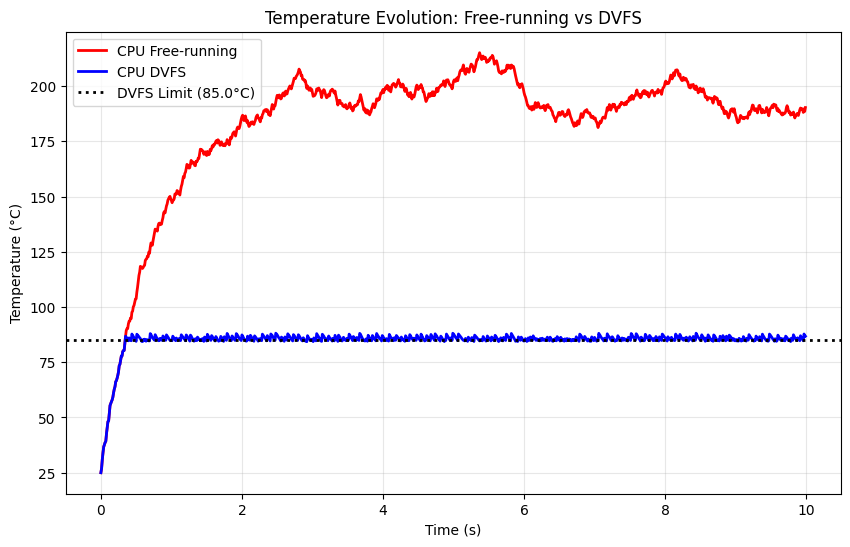

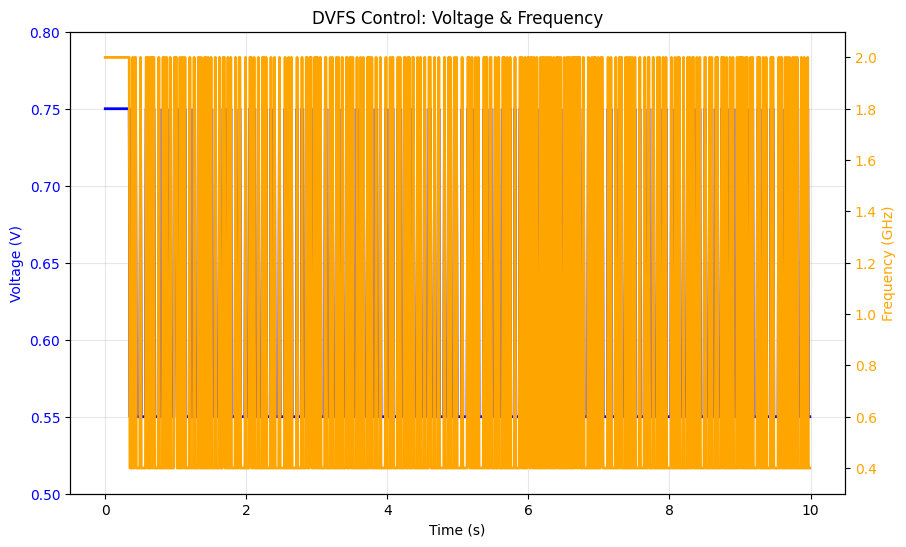

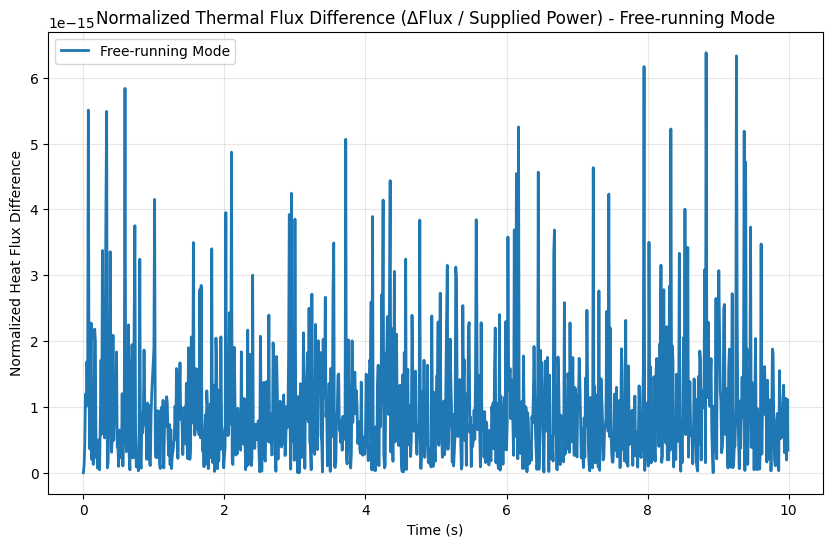

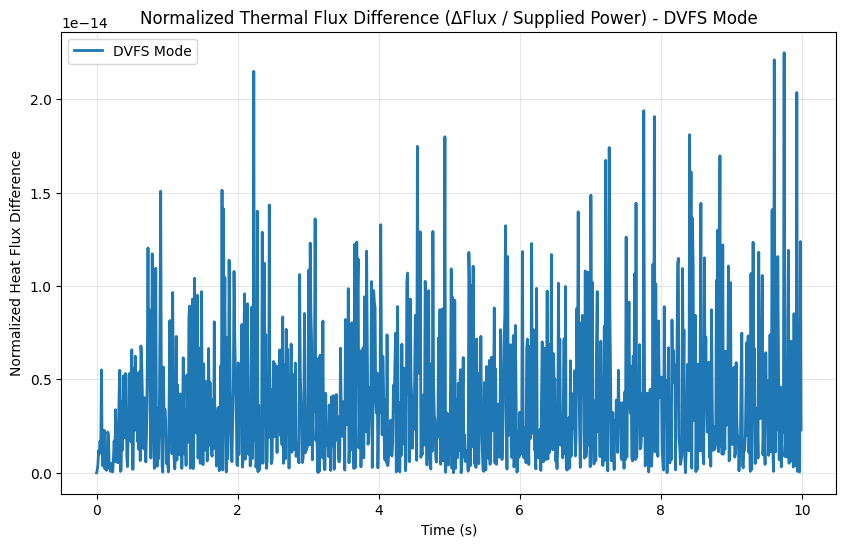

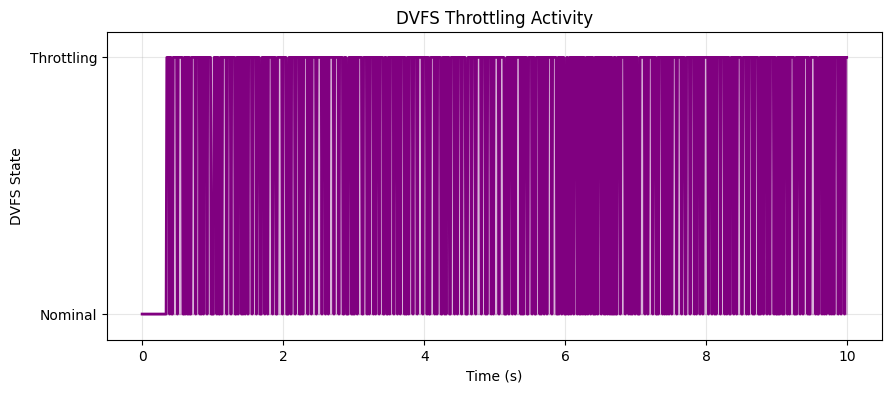

In [14]:
def main():
    """Main function to run the complete simulation"""
    # Get simulation parameters
    params = get_default_params()
    
    # Create time vector
    time = np.arange(0, params['duration'], params['dt'])
    
    # Generate synthetic Cdyn trace
    cdyn_nom_trace = generate_cdyn_trace(time, seed=42)
    
    print("Running thermal simulations...")
    
    # Run free-running simulation
    print("1. Free-running mode...")
    results_free = run_simulation(cdyn_nom_trace, time, params, use_dvfs=False)
    
    # Run DVFS-controlled simulation
    print("2. DVFS-controlled mode...")
    results_dvfs = run_simulation(cdyn_nom_trace, time, params, use_dvfs=True)
    
    # Print summary
    print_simulation_summary(results_free, results_dvfs, params)
    
    # Create plots
    print("\nGenerating plots...")
    fig1 = plot_temperature_comparison(results_free, results_dvfs, params['dvfs_temp_limit'])
    fig2 = plot_dvfs_control(results_dvfs, params)
    fig3 = plot_thermal_balance(results_free, label='Free-running Mode')
    fig4 = plot_thermal_balance(results_dvfs, label='DVFS Mode')
    fig5 = plot_dvfs_activity(results_dvfs)
    
    plt.show()
    
    return results_free, results_dvfs, params

# Run the simulation when script is executed
if __name__ == "__main__":
    results_free, results_dvfs, params = main()

# Optional Work: Thermal Dimensioning Analysis

## Context
From the first exercise, I observed that CPU temperature exceeded target levels when thermal regulation was disabled. This led to investigating the theoretical thermal limits of the processor.

## Objective
Determine the frequency-utilization combinations that define the processor's thermal design capacity under constant load conditions.

## Method
- **1 hour simulation** to approximate thermal equilibrium (without implementing a full steady-state model, more than enoug since the system's time constant is around one second)
- **Parameter sweep**: Cdyn (0.1-1.0 W/GHz) vs Frequency (f_min to f_nom)
- **Grid analysis**: 20×20 temperature map

## Results
Contour plot showing CPU temperature distribution with 85°C and 150°C thermal thresholds highlighted.

## Limits of this study:
The physical model assumes a constant thermal equivalent. However, this model shows limitations at temperatures around 150°C to 200°C, as thermal radiation becomes non-negligible and exhibits a tendency proportional to T⁴. Consequently, this study highlights only the regions where temperatures exceed 150°C, as these areas are already indicative of thermal runaway conditions, making further steady-state calculations unnecessary.

In [15]:
def compute_voltage(frequency, params):
    """
    Compute voltage based on a linear correlation with frequency.
    v_min + (v_nom - v_min) * (frequency - f_min) / (f_nom - f_min)
    """
    v_min = params["v_min"]
    v_nom = params["v_nom"]
    f_min = params["f_min"]
    f_nom = params["f_nom"]

    return v_min + (v_nom - v_min) * (frequency - f_min) / (f_nom - f_min)





def run_transient_simulation_constant_cdyn(cdyn_nom, frequency, params):
    voltage = compute_voltage(frequency, params)
    time = np.arange(0, params["duration"], params["dt"])
    n_steps = len(time)
    
    temps = {
        'cpu': np.full(n_steps, params["T_amb"]),
        'board': np.full(n_steps, params["T_amb"]),
        'pkg': np.full(n_steps, params["T_amb"]),
        'soc': np.full(n_steps, params["T_amb"])
    }


    for i in range(n_steps - 1):
        P_total, _, _ = compute_total_power(cdyn_nom, voltage, temps['cpu'][i], params)
        new_temps = simulate_thermal_step(
            {
                'cpu': temps['cpu'][i],
                'board': temps['board'][i],
                'pkg': temps['pkg'][i]
            },
            P_total,
            params,
            dt=params["dt"]
        )        
        
        temps['cpu'][i + 1] = new_temps['cpu']
        temps['board'][i + 1] = new_temps['board']
        temps['pkg'][i + 1] = new_temps['pkg']
        temps['soc'][i + 1] = new_temps['soc']

    mean_cpu_temp_last_second = np.mean(temps['cpu'][-int(1 / params["dt"]):])
    return mean_cpu_temp_last_second

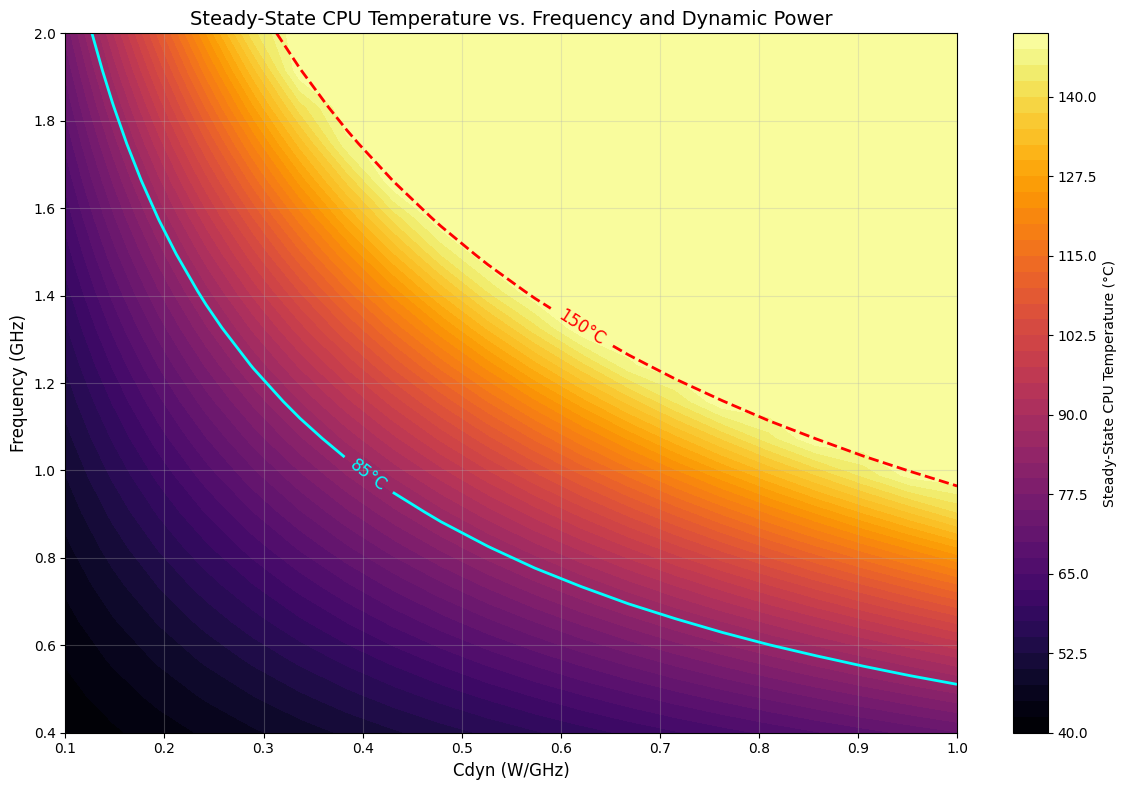

In [16]:
# === Mesh Generation and Average CPU Temperatures ===

params = get_default_params()
# As the characteristic time constant is on the order of one second, setting an arbitrary calculation time of one hour is more than sufficient to ensure thermal equilibrium is reached.
params["duration"] = 3600
params["dt"] = 1
cdyn_values = np.linspace(0.1, 1.0, 20)  # Cdyn range (W/GHz)
freq_values = np.linspace(params["f_min"], params["f_nom"], 20)  # Frequency range (GHz)
T_cpu_grid = np.zeros((len(freq_values), len(cdyn_values)))  # Initialize temperature grid

# Run the transient simulation for each combination of Cdyn and frequency
for i, freq in enumerate(freq_values):
    for j, cdyn in enumerate(cdyn_values):
        T_cpu_grid[i, j] = run_transient_simulation_constant_cdyn(cdyn, freq, params)

# Convert temperature from Kelvin (K) to Celsius (°C)
T_cpu_C = T_cpu_grid - 273.15
X, Y = np.meshgrid(cdyn_values, freq_values)  # Create a mesh grid for plotting

# Clip temperatures to max 150°C for color scaling
T_cpu_C_clipped = np.clip(T_cpu_C, a_min=T_cpu_C.min(), a_max=150)

# Plot
plt.figure(figsize=(12, 8))
contour = plt.contourf(X, Y, T_cpu_C_clipped, levels=50, cmap='inferno', vmin=T_cpu_C.min(), vmax=150)
cbar = plt.colorbar(contour, label="Steady-State CPU Temperature (°C)")

# Threshold line at 85°C and 150°C
cs_85 = plt.contour(X, Y, T_cpu_C, levels=[85], colors='cyan', linewidths=2)
plt.clabel(cs_85, fmt="85°C", inline=True, fontsize=12, colors='cyan')
cs_150 = plt.contour(X, Y, T_cpu_C, levels=[150], colors='red', linewidths=2, linestyles='--')
plt.clabel(cs_150, fmt="150°C", inline=True, fontsize=12, colors='red')


plt.xlabel("Cdyn (W/GHz)", fontsize=12)
plt.ylabel("Frequency (GHz)", fontsize=12)
plt.title("Steady-State CPU Temperature vs. Frequency and Dynamic Power", fontsize=14)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Exact temperature values above 150°C are not plotted, as the physical model is considered unreliable beyond this limit. Moreover, there is no need to calculate precise values above 150°C since the CPU would be damaged in any case. The simulation only identifies regions where this threshold is exceeded, without providing accurate temperature values.

Observation on the graph : 
1) The CPU demonstrates a well-defined safe operating region below the 85°C threshold. It confirms adequate thermal design for typical workloads.
2) The graph shows that the CPU can achieve thermal equilibrium under any operating condition by reducing frequency to minimum values.
3) At maximum frequency (2.0 GHz), the CPU can still operate stably at low dynamic capacitance values.

## Improvement and Perspectives:

### DVFS System Enhancement

- **Proportional regulation**: Replace current system with proportional CPU frequency adjustment to avoid oscillations between f_nom and f_min
- **PID implementation**: With caution due to potential strong oscillations and temperature overshoots
- **Thermal map utilization**: Using average equilibrium temperature data for each control state to improve frequency stability and thermal performance, enhancing CPU efficiency and reducing thermal stress on components.

### Real Data Testing

- **Real Cdyn signal**: Move from purely theoretical approaches to tests on actual dynamic consumption signals